# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import shap

# Read Data

In [35]:
data = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")

# Data Summary Stats

In [36]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [37]:
# Percentage of missing values per column with Nan values
missing_percentage = data.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]
missing_percentage = missing_percentage.sort_values(ascending=False)
print(missing_percentage)

Outlet_Size    28.276428
Item_Weight    17.165317
dtype: float64


# Preprocessing

In [38]:
def preprocess(df):
    # To fill missing Item_Weight with mean of training data
    df['Item_Weight'].fillna(data['Item_Weight'].mean(), inplace=True)
    
    # To fill missing Outlet_Size with 'No data'
    df['Outlet_Size'] = df['Outlet_Size'].fillna('No data')
    
    \
    # To fix inconsistent labels (lf,low fat,reg) in Item_Fat_Content
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({
        'LF': 'Low Fat',
        'low fat': 'Low Fat',
        'reg': 'Regular'
    })
    return df

In [39]:
data = preprocess(data)
test = preprocess(test)

# EDA

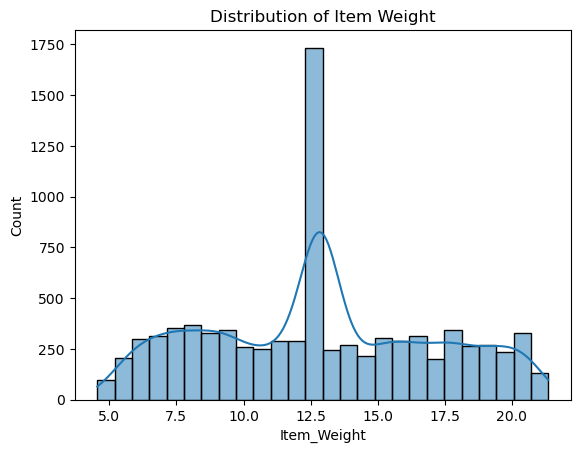

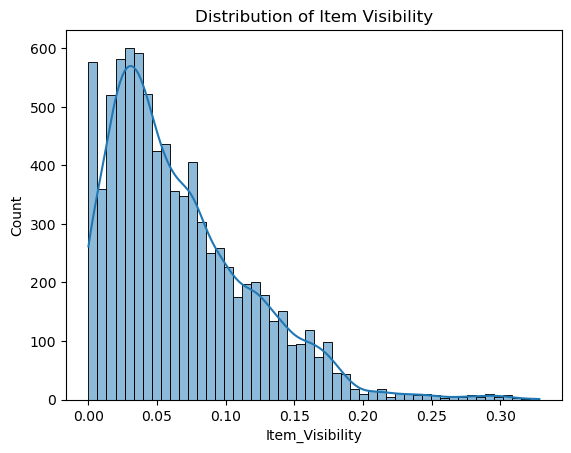

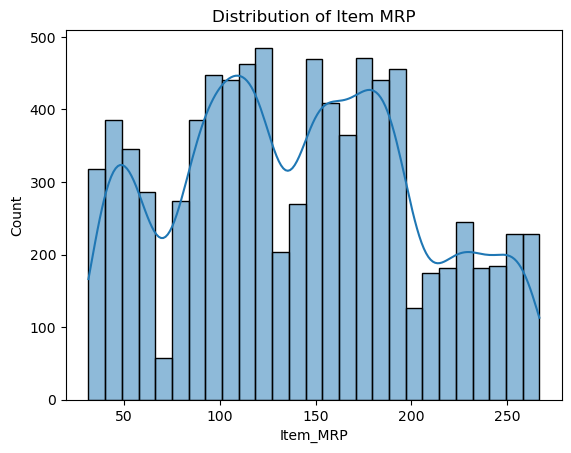

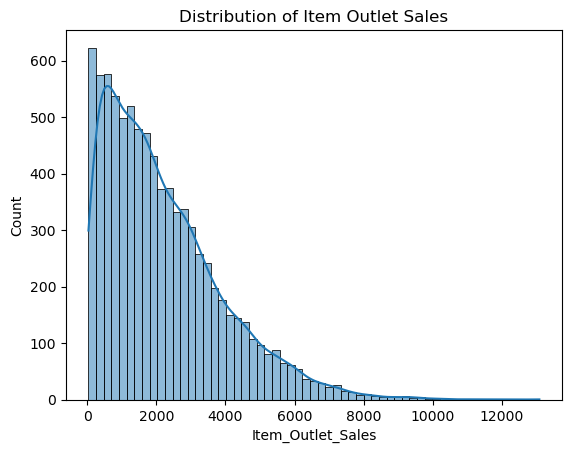

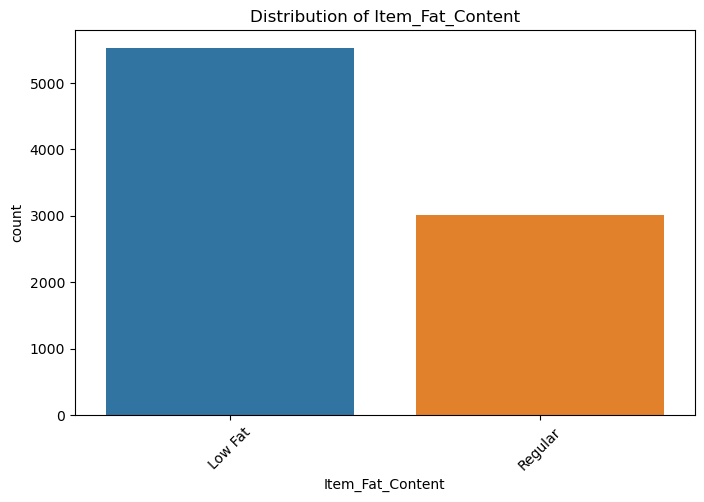

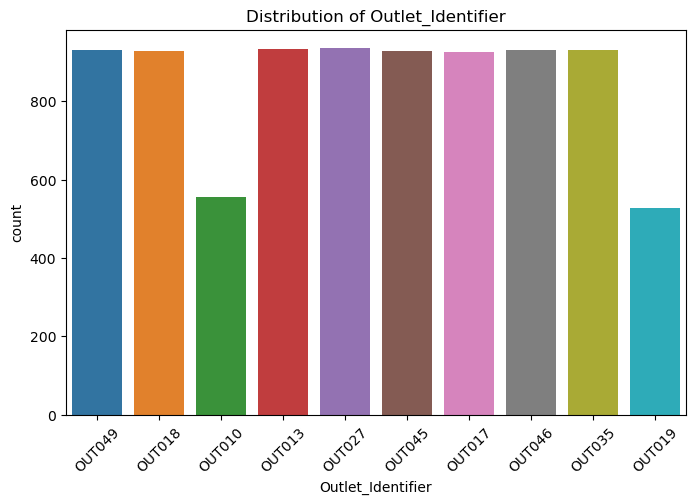

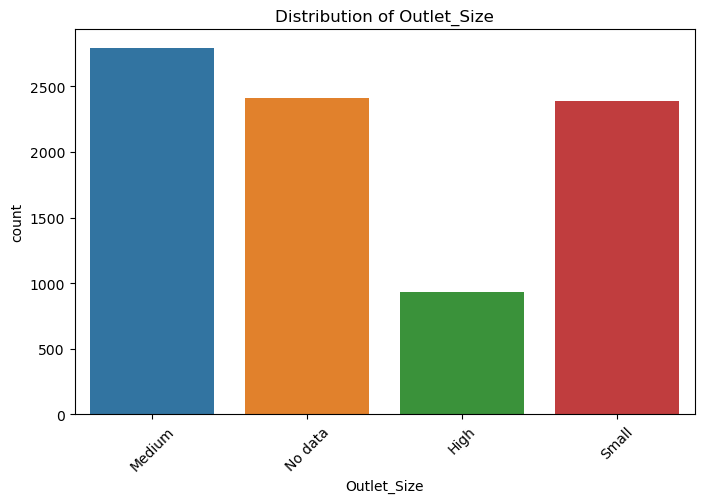

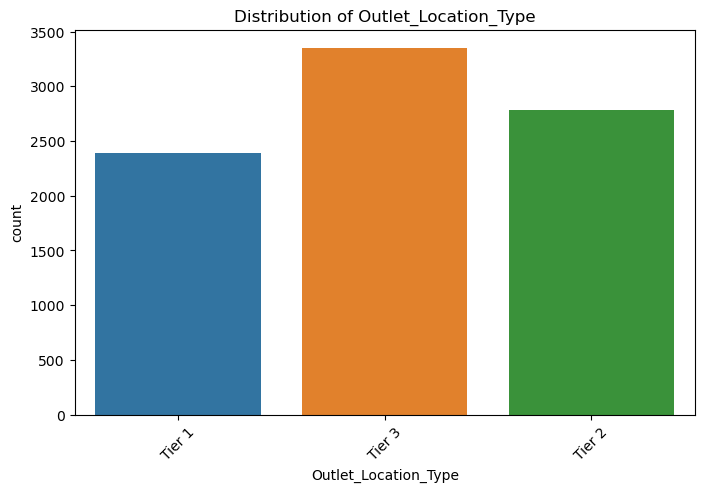

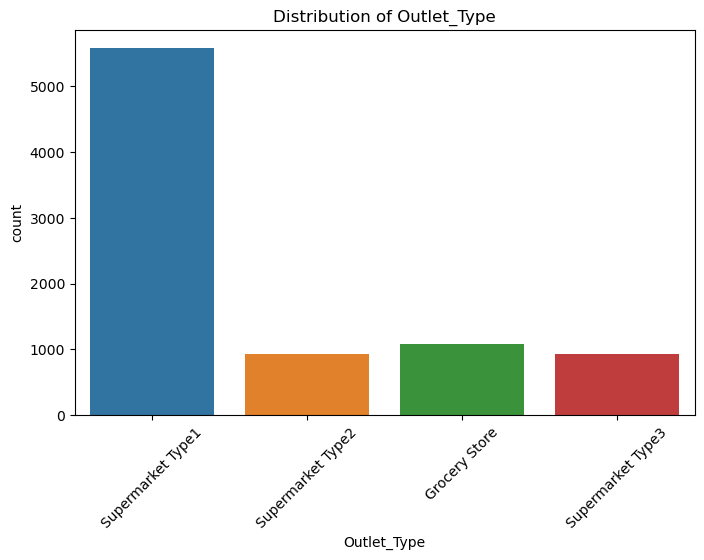

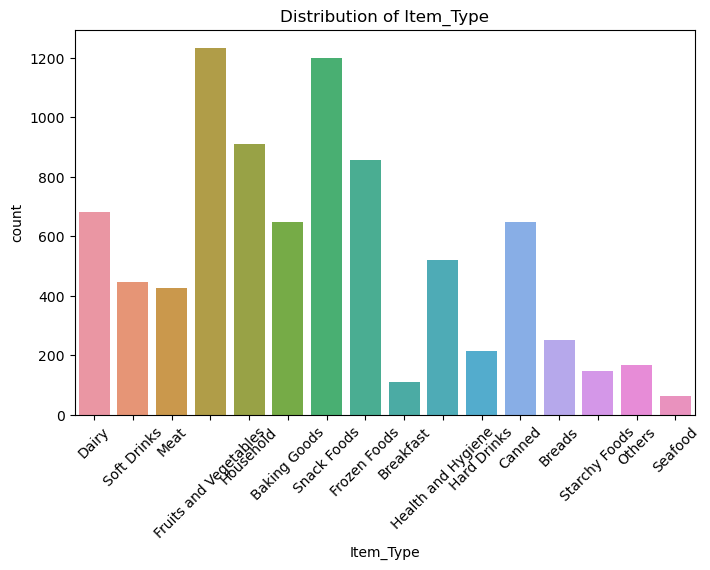

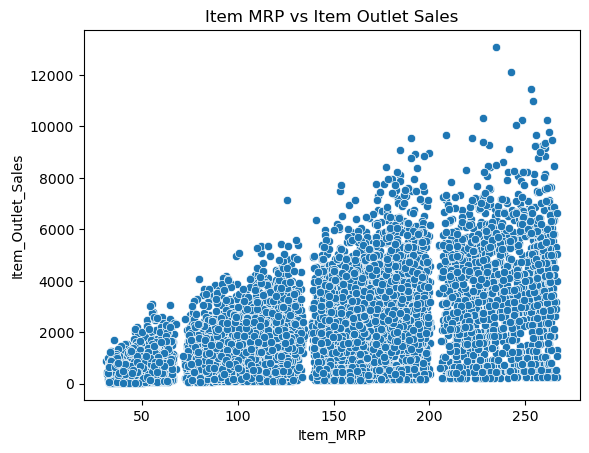

In [40]:
# Distribution of Item_Weight
sns.histplot(data['Item_Weight'], kde=True)
plt.title('Distribution of Item Weight')
plt.show()

# Distribution of Item_Visibility
sns.histplot(data['Item_Visibility'], kde=True)
plt.title('Distribution of Item Visibility')
plt.show()

# Distribution of Item_MRP
sns.histplot(data['Item_MRP'], kde=True)
plt.title('Distribution of Item MRP')
plt.show()

# Distribution of Item_Outlet_Sales
sns.histplot(data['Item_Outlet_Sales'], kde=True)
plt.title('Distribution of Item Outlet Sales')
plt.show()

categorical_columns = ['Item_Fat_Content', 'Outlet_Identifier', 'Outlet_Size', 
                       'Outlet_Location_Type', 'Outlet_Type', 'Item_Type']

for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()
    
# Item_MRP vs Item_Outlet_Sales
sns.scatterplot(x=data['Item_MRP'], y=data['Item_Outlet_Sales'])
plt.title('Item MRP vs Item Outlet Sales')
plt.show()    

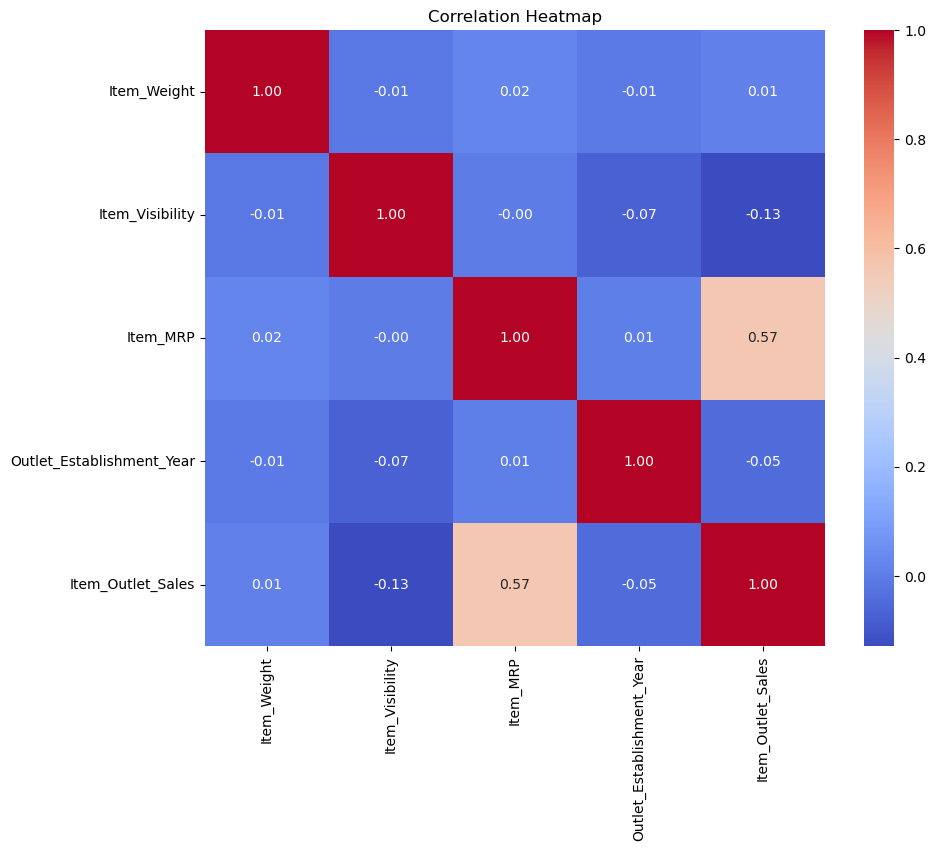

In [41]:
# correlation
numeric_cols = data.select_dtypes(include=['number']).columns
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Feature Engineering

In [42]:
data['Outlet_Age'] = 2025 - data['Outlet_Establishment_Year']
test['Outlet_Age'] = 2025 - test['Outlet_Establishment_Year']

data['Item_Visibility_Scaled'] = data['Item_Visibility'].apply(lambda x: x if x > 0 else 0.01)
test['Item_Visibility_Scaled'] = test['Item_Visibility'].apply(lambda x: x if x > 0 else 0.01)

# Encoding Categorical variables

In [43]:
label_encoders = {}
for col in ['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type','Outlet_Size']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    test[col] = le.transform(test[col])  # Transform test data with the same encoder
    label_encoders[col] = le

# Setting target 

In [44]:
X = data.drop(['Item_Identifier','Item_Outlet_Sales','Outlet_Identifier','Outlet_Establishment_Year'], axis=1)
y = data['Item_Outlet_Sales']

X_test = test.drop(['Item_Identifier', 'Outlet_Identifier','Outlet_Establishment_Year'], axis=1)

# Split for train and cross validation

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Build

In [46]:
# Model 1: Random Forest Regressor
rf_model = RandomForestRegressor()

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Hyperparameter tuning for Random Forest using GridSearchCV
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF Score (RMSE):", (-rf_grid.best_score_)**0.5)

# Model 2: XGBoost Regressor
xgb_model = XGBRegressor()

xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Hyperparameter tuning for XGBoost using GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost Score (RMSE):", (-xgb_grid.best_score_)**0.5)

# Model 3: Stacking Model
rf_model_tuned = RandomForestRegressor(n_estimators=200, max_depth=10)
xgb_model_tuned = XGBRegressor(n_estimators=200, learning_rate=0.1)

meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=[('rf', rf_model_tuned), ('xgb', xgb_model_tuned)], final_estimator=meta_model)

Best RF Params: {'max_depth': 5, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100}
Best RF Score (RMSE): 1096.6455890158834
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best XGBoost Score (RMSE): 1092.7784314250162


<b> CV for stacking model </b>

In [47]:
# Cross-validation for Stacking Model
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Stacking Model RMSE (CV):", (-cv_scores.mean())**0.5)

Stacking Model RMSE (CV): 1110.7084828235645


<b> Model evaluation on Validation set </b>

In [48]:
rf_pred = rf_grid.predict(X_val)
xgb_pred = xgb_grid.predict(X_val)
stack_pred = stacking_model.fit(X_train, y_train).predict(X_val)

<b> RMSE Calcs </b>

In [49]:
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
stack_rmse = np.sqrt(mean_squared_error(y_val, stack_pred))

print(f'Random Forest RMSE: {rf_rmse}')
print(f'XGBoost RMSE: {xgb_rmse}')
print(f'Stacking Model RMSE: {stack_rmse}')

Random Forest RMSE: 1019.715532130238
XGBoost RMSE: 1028.6545881982859
Stacking Model RMSE: 1039.5164657088887


# Feature Importances and SHAP

<b> Combining the FE for xgb and rf to get a comparison </b>

<Figure size 1400x800 with 0 Axes>

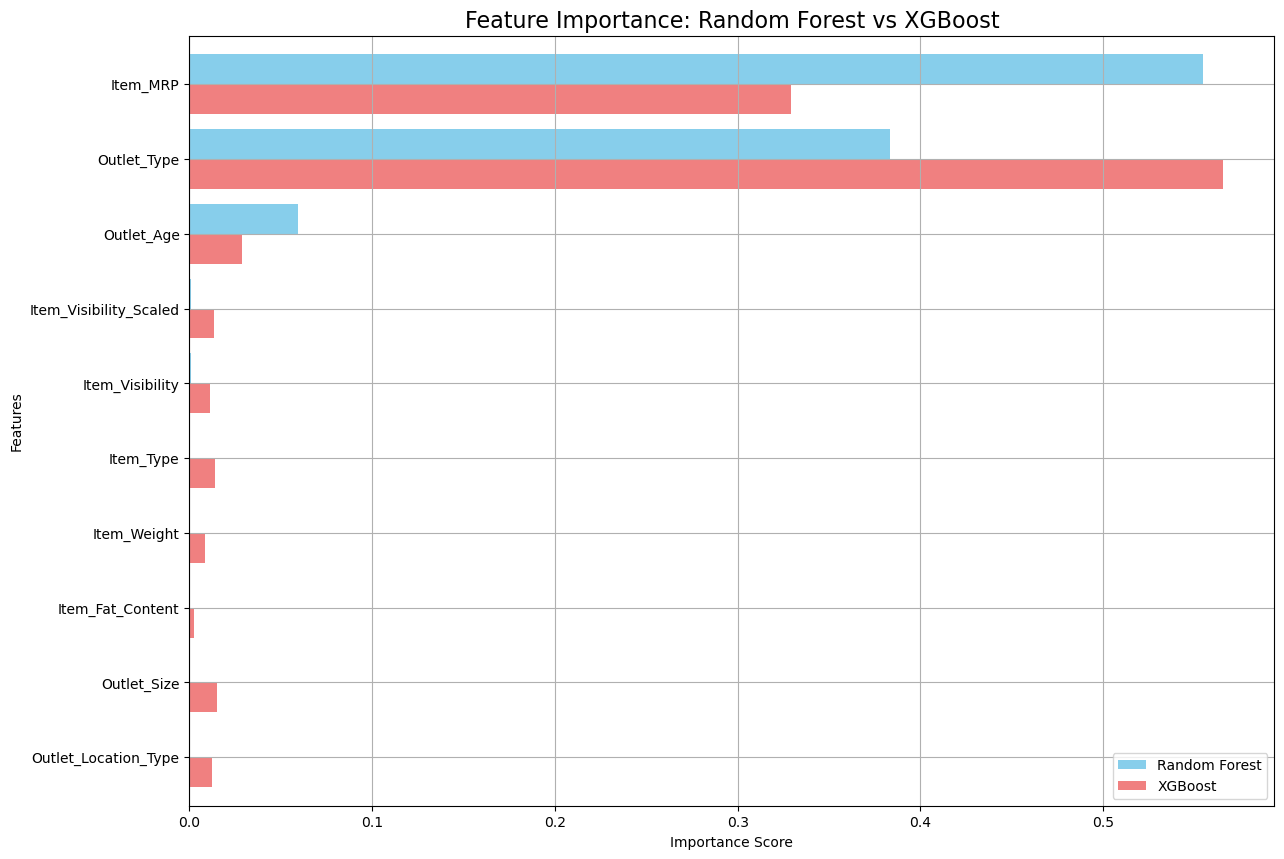

In [50]:
# Random Forest Feature Importance
rf_importances = pd.Series(rf_grid.best_estimator_.feature_importances_, index=X_train.columns)

# XGBoost Feature Importance
xgb_importances = pd.Series(xgb_grid.best_estimator_.feature_importances_, index=X_train.columns)
feature_importance_df = pd.DataFrame({
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances
})

feature_importance_df = feature_importance_df.sort_values('Random Forest', ascending=False)

plt.figure(figsize=(14, 8))
feature_importance_df.plot(kind='barh', figsize=(14, 10), width=0.8, color=['skyblue', 'lightcoral'])
plt.title('Feature Importance: Random Forest vs XGBoost', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

<b> SHAP </b>

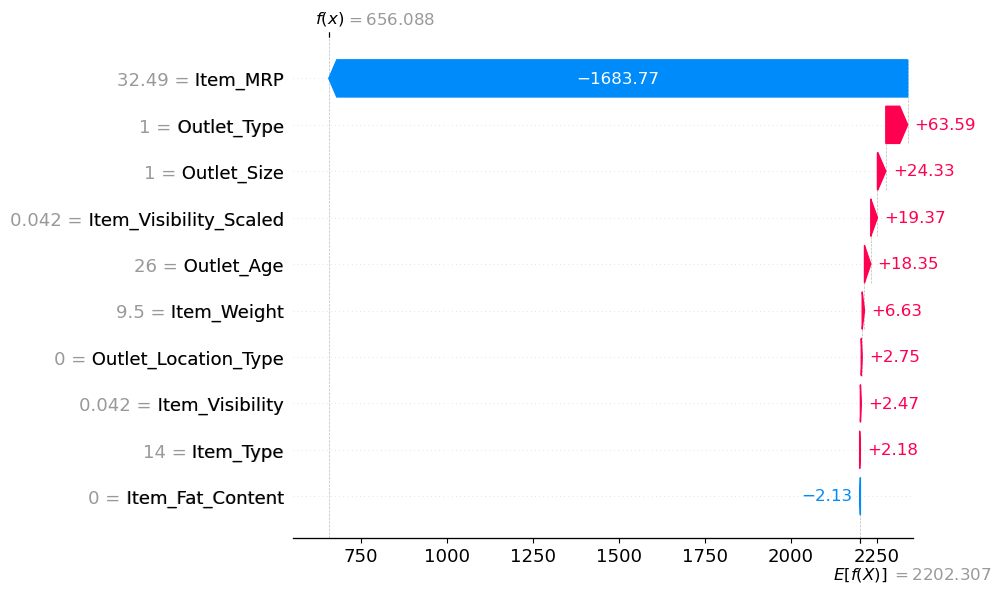

In [51]:
explainer = shap.Explainer(xgb_grid.best_estimator_)

sample_idx = 5
sample = X_val.iloc[[sample_idx]]

shap_values = explainer(sample)

shap.plots.waterfall(shap_values[0])

# Test Predictions

In [53]:
rf_test_pred = rf_grid.predict(X_test)
xgb_test_pred = xgb_grid.predict(X_test)
stack_test_pred = stacking_model.fit(X_train, y_train).predict(X_test)

In [54]:
# final ensemble prediction (simple average of predictions)
final_test_pred = (rf_test_pred + xgb_test_pred + stack_test_pred) / 3

In [55]:
# Preparing the submission file
submission = pd.DataFrame({'Item_Identifier': test['Item_Identifier'],
                           'Outlet_Identifier': test['Outlet_Identifier'],
                           'Item_Outlet_Sales': final_test_pred})

submission.to_csv('submission_el_mt_cv_4.csv', index=False)

print("Submission file created!")

Submission file created!
